<a id='Top'/>

# Analysis of baseball dataset
[Cedric Campguilhem](https://github.com/ccampguilhem/Udacity-DataAnalyst)

## Table of contents

- [Prelude](#Prelude)
- [Introduction](#Introduction)
    - [Dataset description](#Dataset description)
    - [Questions](#Questions)
- [Data wrangling](#Data wrangling)
    - [Master dataset](#Master dataset)
    - [Wrap up](#Wrap up)
- [Exploration](#Exploration)
    - [Who plays baseball?](#Who plays baseball)
    - [Typical carrier of a baseball player](#Typical carrier)
- [Conclusions](#Conclusions)
- [Appendix](#Appendix)

<a id='Prelude'/>

## Prelude *[top](#Top)*

This notebook is a re-submission of the project. The analysis remains almost the same but few changes have been brought:
* **Seaborn** has been used for anything related to plotting. I was using in the first submission a mix of pandas plot capabilities and some matplotlib functions of my own.
* The **data wrangling** phase was previously made in a separate Python module and at different locations in notebook throughout the analysis, so I have regrouped most of the data wrangling in a dedicated section of the notebook. External module is then not required anymore. I also have added comments about missing values and outliers that were missing in previous submission.
* The **notebook structure** has been reworked so that outline is better defined at the start of analysis and I have added a table of contents at the start so that it's easier to jump to locations in the notebook as it is now significantly larger. It also better reflects the whole data analysis process:
    * Ask questions
    * Wrangle
    * Explore
    * Draw conclusions
    * Communicate

<a id='Introduction'>

## Introduction *[top](#Top)*

This notebook is a project for the [Udacity Data Analyst Nanodegree Program](https://www.udacity.com/course/data-analyst-nanodegree--nd002) part of the Introduction to Data Analysis lesson. The lesson is about both numpy and pandas but as I a am a long time user of numpy I prefer to focus on pandas.

I have chosen to investigate the baseball dataset through the eyes af an european profane.

<a id='Dataset description'>

### Dataset description *[top](#Top)*

The database has been collected by [Sean Lahman](http://www.baseball1.com) and contains statistics for the Major League Baseball from 1871 to nowdays.

The database used in this project comes in a series of 27 csv files with various information releated to players, teams, batting statistics and much more. I only have used a subset of this database to perform the analysis. Dataset used will be explained in the [data wrangling](#Data wrangling) section.

<a id='Questions'>

### Questions *[top](#Top)*

As I am absolutely profane in baseball, I want first to see who plays baseball in the Major League Baseball and I come with a first series of questions:

- Where players are from (country) ?
- When (age) players make ther debut ? 
- When (age) players usally retire ? 
- How long lasts a baseball carrier ?
- What is the the morphotype of a baseball player ? 
- Has the average morphotype changed in history of baseball ?

I also want to be a bit more familiar with different teams playing in the two major leagues (American League and National League) and here are the questions I have:

- Which are active teams in National League and American League ?
- Is there any team that changed league or division in its history ?
- How many titles (league winner) teams have in their respective league (including non-active teams) ?
- Which are the teams with the most wins in World Series in history ?
- How many world series have been won by teams from National League and American League ?
- Which teams have the best win ratio after regular season ?
- Which teams have the best average win ratio on multiple seasons ?
- How attendance is related to win ratio in league ?

Throught the exploration of teams, one specific team (Seattle Mariners) caught my attention. As we will see later in the notebook, this team present a weird specificity:

- The team holds the records of wins in a season (2001)...
- ...and is part of the few teams which has never won the League (and World Series as a consequence).
- The 2001 season was also exceptional for the team compared to the results of previous and later seasons.

My list of questions has then be enriched:

- Was there any change in the team (manager and players) in 2001 ?
- How new recruits had contributed to the team success and how they compared to the rest of players in the league ?

<a id='Data wrangling'>

## Data wrangling *[top](#Top)*

<a id="Master dataset"/>

Before we start, we need to import all the librairies and define global variables we need:

In [266]:
#Python standard library
import os
import datetime
import functools

#Pandas data analysis library and numpy array library
import pandas as pd
import numpy as np

#Seaborn visualization library
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
#Path of datasets
DATASET_PATH = "./dataset/core"

In [65]:
#Enable inline plots in the report
%matplotlib inline

In [71]:
#Configure seaborn plot style
sns.set_style('whitegrid')
sns.despine()

In [283]:
#Configure grouping of players by birth date. This is used in master dataset cleaning to add a categorical field
BIRTH_PERIODS = [1900, 1930, 1960, 1990]

In [295]:
#The following functions enable to control the appearance of plots using the birth period categorcial field
def birth_periods_order(periods):
    """
    Return the name of categorical fields based on specified periods.
    
    For example, if periods specified are [1900, 1950, 2000], the return list is:
    ["<1900", "[1900, 1950)", "[1950, 2000)", ">2000"]
    
    - periods: a sequence of birth year
    - return: sorted list of categorical values
    """
    values = []
    for i in xrange(len(periods) + 1):
        if i == 0:
            values.append("<{0}".format(periods[0]))
        elif i == len(periods):
            values.append(">={0}".format(periods[i-1]))
        else:
            values.append("[{0}, {1})".format(periods[i-1], periods[i]))
    return values

### Master dataset *[top](#Top)*

The master dataset includes players and manager biography. When they have made their debut, final game, where they are from but also their height and weight. So basically, this dataset by its own is enough to answer my first series of [questions](#Questions).

Here is the description of the dataset provided with the database:

```
playerID       A unique code asssigned to each player.  The playerID links
               the data in this file with records in the other files.
birthYear      Year player was born
birthMonth     Month player was born
birthDay       Day player was born
birthCountry   Country where player was born
birthState     State where player was born
birthCity      City where player was born
deathYear      Year player died
deathMonth     Month player died
deathDay       Day player died
deathCountry   Country where player died
deathState     State where player died
deathCity      City where player died
nameFirst      Player's first name
nameLast       Player's last name
nameGiven      Player's given name (typically first and middle)
weight         Player's weight in pounds
height         Player's height in inches
bats           Player's batting hand (left, right, or both)         
throws         Player's throwing hand (left or right)
debut          Date that player made first major league appearance
finalGame      Date that player made first major league appearance (blank if still active)
retroID        ID used by retrosheet
bbrefID        ID used by Baseball Reference website
```


There are few fields in the dataset that I am not interested with and that will be dropped. 

Dates (birth, debut, final game) are also collected in a non-consistent way so I have re-formatted them as Python datetime objects, that will help me doing some math with dates later on. Yet, I have kept the birthYear field for convenience. I also have added a categorical field (birthPeriod) which group players based on their birth date.

Some players have no playerID, I have removed them from the dataset.

Few countries are recorded using abbreviations, I have replaced it with full name.

I also have assembled in a fullName field the first and last names of players and managers.

I am not used to US units of height and weight so I have converted values in centimeters and kilograms.

Finally, I am using the playerID field as index of the master data frame.

Here are the functions used to clean the dataset. They will be used in `apply`, `applymap` and `assign` methods of pandas data frames objects:

In [296]:
def rename_countries(country):
    """
    Rename country.
    
    Removes abreviations in country names.
    
    - country: country to be renamed
    + return: renamed country
    """
    if country == "CAN":
        return "Canada"
    elif country == "D.R.":
        return "Dominican Republic"
    elif country == "P.R.":
        return "Puerto Rico"
    elif country == "V.I.":
        return "British Virgin Islands"
    else:
        return country
        

def convert_units(column):
    """
    Convert units in given column.
    
    Inches are converted into centimeters and pounds are converted into 
    kilograms.
    
    - column: series to be converted
    - return: series with converted units
    """
    if column.name == "weight":
        return column * 0.453592
    elif column.name == "height":
        return column * 2.54
    else:
        return column
        
        
def convert_dates(column):
    """
    Convert dates from string to date time objects.
    
    The dates format are YYYY-MM-DD in the input data.
    
    - column: series to be converted
    - return: series with datetime data type
    """
    def _convert_date(date):
        try:
            return datetime.datetime.strptime(date, "%Y-%m-%d")
        except TypeError:
            return date
    
    if column.name in ["debut", "finalGame"]:
        return column.apply(_convert_date)
    else:
        return column


def combine_names(df):
    """
    Combine first and last name in a series.
    
    - df: master data frame
    - return: series with full name
    """
    return pd.Series(["%s %s" % (first, last) for (first, last) in zip(df[u"nameFirst"], df[u"nameLast"])])


def group_by_birth_year(df, bins):
    """
    Group row in data frame by birth year as specified by user.
    
    The following categories are created:
    - birthYear < bins[0]
    - bins[0] <= birthYear < bins[1]
    - ...
    - bins[n-1] <= birthYear < bins[n]
    - birthYear >= bins[n]
    
    - df: input data frame
    - bins: definition of bins intervals
    - return: series with categories
    """
    birthYear = df["birthYear"]
    series = np.zeros(shape=len(birthYear), dtype=object)
    values = birth_periods_order(bins)
    for i in xrange(len(bins) + 1):
        if i == 0:
            series[birthYear < bins[0]] = values[0]
        elif i == len(bins):
            series[birthYear >= bins[i-1]] = values[-1]
        else:
            mask_low = bins[i-1] <= birthYear
            mask_high = birthYear < bins[i]
            series[np.logical_and(mask_low, mask_high)] = values[i]
    return pd.Series(series, index=birthYear.index)


def clean_master(df):
    """
    Clean the master data frame
    
    Drop unused columns, drop any row with a null player ID and uses playerID
    as index. Convert height and weight units, create a new column with birth 
    date as datetime object and convert debut and finalGame dates into datetime
    objects.
    
    - df: master data frame
    - return: cleaned data frame
    """
    #Drop rows where player ID is null
    df.dropna(axis=0, subset=['playerID'], inplace=True)
    
    #Create a datetime object for birth date (not sure if it can be vectorized)
    birth_year = df["birthYear"]
    birth_month = df["birthMonth"]
    birth_day = df["birthDay"]
    birth_date = [ ]
    for (year, month, day) in zip(birth_year, birth_month, birth_day):
        try:
            birth_date.append(datetime.datetime(int(year), int(month), 
                    int(day)))
        except ValueError:
            birth_date.append(None)
    df = df.assign(birthDate=birth_date)
    
    #We create a new categorical field birth period
    #We use a little trick here to adapt our function to what assign method expects
    group_function = functools.partial(group_by_birth_year, bins=BIRTH_PERIODS)
    df = df.assign(birthPeriod=group_function)

    #Combine first name and last name into a full name:
    df = df.assign(fullName=combine_names)
    
    #Drop unused columns
    df.drop(["birthMonth", "birthDay", "birthState", "birthCity", "deathYear", 
             "deathMonth", "deathDay", "deathCountry", "deathCity", 
             "deathState", "bats", "throws", "bbrefID", "retroID", 
             "nameFirst", "nameLast", "nameGiven"], 
             axis=1, inplace=True)
 
    #Rename countries (element-wise operation)
    df = df.applymap(rename_countries)
    
    #Convert units (column-wise operation)
    df = df.apply(convert_units)
    
    #Convert dates
    df = df.apply(convert_dates)
    
    #Set player ID as index, we do this at the end otherwise the assign of new series fails 
    df.set_index("playerID", inplace=True)

    return df

The master dataframe may now be read and cleaned:

In [297]:
master_df = clean_master(pd.read_csv(os.path.join(DATASET_PATH, "Master.csv")))
master_df.head()

,birthYear,birthCountry,weight,height,debut,finalGame,birthDate,birthPeriod,fullName
playerID,,,,,,,,,
aardsda01,1981.0,USA,97.522280,190.50,2004-04-06,2015-08-23,1981-12-27,"[1960, 1990)",David Aardsma
aaronha01,1934.0,USA,81.646560,182.88,1954-04-13,1976-10-03,1934-02-05,"[1930, 1960)",Hank Aaron
aaronto01,1939.0,USA,86.182480,190.50,1962-04-10,1971-09-26,1939-08-05,"[1930, 1960)",Tommie Aaron
aasedo01,1954.0,USA,86.182480,190.50,1977-07-26,1990-10-03,1954-09-08,"[1930, 1960)",Don Aase
abadan01,1972.0,USA,83.460928,185.42,2001-09-10,2006-04-13,1972-08-25,"[1960, 1990)",Andy Abad


This dataset is mainly explored in the [Who plays baseball?](#Who plays baseball) and [Typical carrier of a baseball player](#Typical carrier) sections.

<a id='Teams dataset'/>

### Teams dataset *[top](#Top)*

blabla

<a id='Wrap up'/>

### Wrap up *[top](#Top)*

The dataset used in the analysis are the following ones:

Name      | Description                                     | Source        | Explored in sections
:---------|:------------------------------------------------|:------------- |:---------------------
master_df | Player and manager biography, height and weight | Master.csv    | [Who plays baseball?](#Who plays baseball) [Typical carrier of a baseball player](#Typical carrier)
teams_df  | Yearly stats and standings in league            | Teams.csv     | 

<a id='Exploration'/>

## Exploration *[top](#Top)*

<a id='Who plays baseball'/>

### Who plays baseball? *[top](#Top)*

#### Country of origin

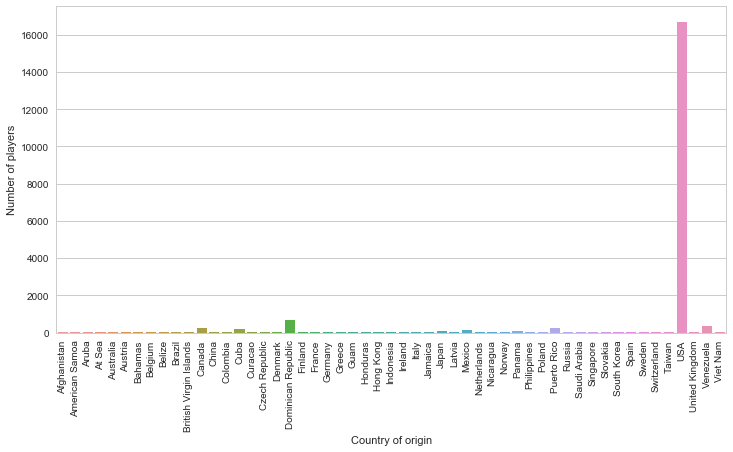

In [298]:
#Some rows have no birthCountry defined, we remove them from the dataset the time we explore the data.
#We also reset the index to "count" the playerID field later on
country_of_origin = master_df[master_df["birthCountry"].notnull()].reset_index()

#We simply group players and managers by birth country and show results in a form of a bar plot
country_of_origin_count = country_of_origin.groupby('birthCountry', as_index=False).count()
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("Number of players")
ax = sns.barplot(x="birthCountry", y="playerID", data=country_of_origin_count, ax=ax)
ax.set(xlabel='Country of origin', ylabel='Number of players')

Players are massively born in the USA. Other major countries of origin are Dominican Republic, Canada, Puerto Rico, Venezuela and Cuba.

#### What is the morphology of a baseball player?

In [299]:
#We remove from the dataframe players who have no recorded weight, height or birth year
weight_and_height = master_df[master_df['weight'].notnull() & master_df['height'].notnull() 
                              & master_df['birthYear'].notnull()]

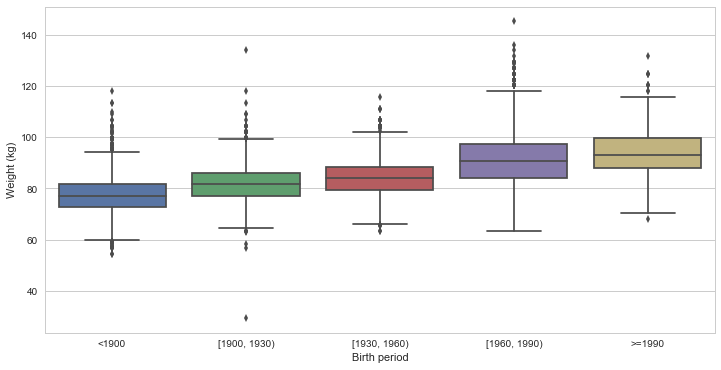

In [300]:
#We use this new categorical field to do a box plot for weight
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
order = birth_periods_order(BIRTH_PERIODS)
ax = sns.boxplot(x="birthPeriod", y="weight", data=weight_and_height, order=order, ax=ax);
ax.set(xlabel='Birth period', ylabel='Weight (kg)')

The box plot displays the 3 quartiles (25%, mean and 50%) along with individuals out of 1.5 interquartile range (outliers). Outliers are represented independently. We can see that they are mostly on the high end of weight. One outlier in the period [1900,1930) is particularly low and one in the [1960, 1990) is particularly high.

The box plot shows that weight of players tend to increase over the years. After 1960, average weight is higher and distribution is more spread out as well.

In [301]:
#We can easilly identify the outliers with very small weight
index = weight_and_height[weight_and_height["birthPeriod"] == "[1900, 1930)"]["weight"].idxmin(axis=0)
weight_and_height.loc[index]

birthYear                      1925
birthCountry                    USA
weight                      29.4835
height                       109.22
debut           1951-08-19 00:00:00
finalGame       1951-08-19 00:00:00
birthDate       1925-06-08 00:00:00
birthPeriod            [1900, 1930)
fullName               Eddie Gaedel
Name: gaedeed01, dtype: object

According to [Wikipedia](https://en.wikipedia.org/wiki/Eddie_Gaedel), Eddie Gaedel was an American with dwarfism who played a single game in Major League Baseball.

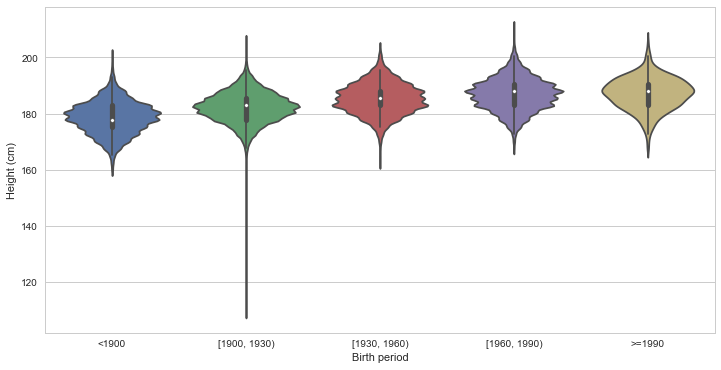

In [302]:
#Alternatively, we can use a violin plot for height distributions over years:
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
order = birth_periods_order(BIRTH_PERIODS)
ax = sns.violinplot(x="birthPeriod", y="height", data=weight_and_height, order=order, ax=ax);
ax.set(xlabel='Birth period', ylabel='Height (cm)')

The violin plot combines a box plot with a [kernel density estimator](https://en.wikipedia.org/wiki/Kernel_density_estimation) which represents an estimate of the probability density function of height.

The height of players has slightly increased. We can still observe the same outlier (Eddie Gaedel) in the [1900, 1930) period. The visibility of outliers and 1.5 interquartile range is less visible in violin plot.

In [303]:
#We can also plot a combination of height and weight in the same plot using join plots for bivariate distributions
#First we remove outliers from the dataset to increase visibility. We remove all player for which either height or 
#weight is beyond 1.5 interquartile range.
def outliers_mask(x):
    """
    Calculate a series mask for outlier values.
    
    A value is an outilier if either one of the following condition is satisfied:
    - value > third quartile + 1.5 * interquartile range
    - value < first quartile - 1.5 * interquartile range
    
    - x: series for which outliers have to been spotted
    - return: mask to get outliers from series
    """
    describe = x.describe()
    first_quartile = describe["25%"]
    third_quartile = describe["75%"]
    iqr = third_quartile - first_quartile
    mask_high = x > (third_quartile + 1.5 * iqr)
    mask_low = x < (first_quartile - 1.5 * iqr)
    return mask_high | mask_low
    
weight_and_height_without_outliers = weight_and_height[~outliers_mask(weight_and_height["weight"])]

#We can check with describe method that outliers have been removed:
weight_and_height_without_outliers.describe()

,birthYear,weight,height
count,18001.000000,18001.000000,18001.000000
mean,1933.777735,84.248295,183.531050
std,39.960536,9.165279,6.516016
min,1835.000000,57.152592,160.020000
25%,1899.000000,77.110640,180.340000
50%,1940.000000,83.914520,182.880000
75%,1970.000000,90.718400,187.960000
max,1996.000000,111.130040,208.280000


The new minimum weight from the dataset is now 57.15 kilograms.

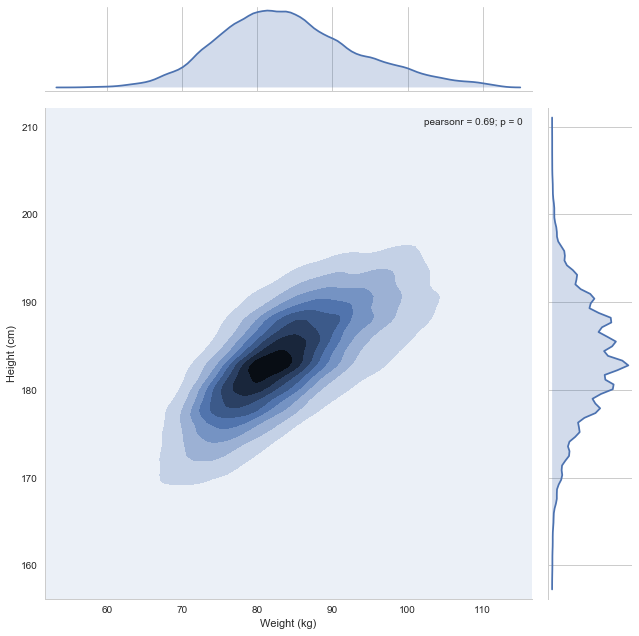

In [304]:
grid = sns.jointplot(x="weight", y="height", kind="kde", data=weight_and_height_without_outliers, size=9);
grid.set_axis_labels(xlabel='Weight (kg)', ylabel='Height (cm)')

The joinplot gives valuable information for the bivariate distribution. First, we can see any univariate distribution in the form of kernell density estimators (KDE) on the top (weight) and on the right (height).

The bivariate distribution (weigh, height) is also displayed in a form of a KDE. We can see that the most common morphotype is ~82 kg for ~182 cm.

Finally, the coefficient of correlation ([Pearson's r coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)) is reported on the plot. The value of 0.69 indicates that variables are correlated which is not surprising: a taller player tends to be heavier.

<a id='Typical carrier'/>

### Typical carrier of a baseball player *[top](#Top)*

#### Age at debut

In [305]:
#We start by removing from the dataset any player for who either birthDate, debut and final game is not recorded)
dates_not_null = master_df[master_df["birthDate"].notnull() & master_df["debut"].notnull()
                           & master_df["finalGame"].notnull()]
dates_not_null.head()

,birthYear,birthCountry,weight,height,debut,finalGame,birthDate,birthPeriod,fullName
playerID,,,,,,,,,
aardsda01,1981.0,USA,97.522280,190.50,2004-04-06,2015-08-23,1981-12-27,"[1960, 1990)",David Aardsma
aaronha01,1934.0,USA,81.646560,182.88,1954-04-13,1976-10-03,1934-02-05,"[1930, 1960)",Hank Aaron
aaronto01,1939.0,USA,86.182480,190.50,1962-04-10,1971-09-26,1939-08-05,"[1930, 1960)",Tommie Aaron
aasedo01,1954.0,USA,86.182480,190.50,1977-07-26,1990-10-03,1954-09-08,"[1930, 1960)",Don Aase
abadan01,1972.0,USA,83.460928,185.42,2001-09-10,2006-04-13,1972-08-25,"[1960, 1990)",Andy Abad


In [362]:
#We calculate age at debut (in years) and carrier length (in years):
delta_to_days = lambda x: float(x.days / 365.25)
age_at_debut = (dates_not_null["debut"] - dates_not_null["birthDate"]).apply(delta_to_days)
carrier_length = (dates_not_null["finalGame"] - dates_not_null["debut"]).apply(delta_to_days)

#We create a dedicated dataframe for this processing
carrier_df = pd.DataFrame({"birthYear": dates_not_null["birthYear"],
                           "birthPeriod": dates_not_null["birthPeriod"],
                           "ageAtDebut": age_at_debut,
                           "carrierLength": carrier_length,
                           "fullName": dates_not_null["fullName"]})
carrier_df.head()

,ageAtDebut,birthPeriod,birthYear,carrierLength,fullName
playerID,,,,,
aardsda01,22.275154,"[1960, 1990)",1981.0,11.378508,David Aardsma
aaronha01,20.183436,"[1930, 1960)",1934.0,22.475017,Hank Aaron
aaronto01,22.680356,"[1930, 1960)",1939.0,9.462012,Tommie Aaron
aasedo01,22.880219,"[1930, 1960)",1954.0,13.188227,Don Aase
abadan01,29.043121,"[1960, 1990)",1972.0,4.588638,Andy Abad


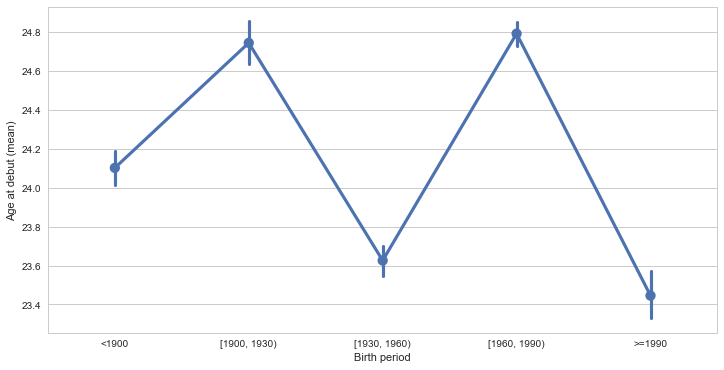

In [363]:
order = birth_periods_order(BIRTH_PERIODS)
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
ax = sns.pointplot(x="birthPeriod", y="ageAtDebut", data=carrier_df, order=order, ax=ax)
ax.set(xlabel="Birth period", ylabel="Age at debut (mean)")

The point plot shows that generally players make their debut in the league at 24 years old. This has only slightly changed in history. The point plot function of seaborn automatically calculate the mean of age at debut and also reports an error estimate for each birth period. The error estimate is larger for the periods >1900 and before 1930. this indicates that we have more variability in age at debut.

In [364]:
#Let's see how many players are born year after years
birth_year_count = carrier_df[["birthYear"]].groupby("birthYear", as_index=False).describe()
birth_year_count.head()

birthYear                                                     
      count    mean  std     min     25%     50%     75%     max
0       1.0  1832.0  NaN  1832.0  1832.0  1832.0  1832.0  1832.0
1       1.0  1835.0  NaN  1835.0  1835.0  1835.0  1835.0  1835.0
2       1.0  1836.0  NaN  1836.0  1836.0  1836.0  1836.0  1836.0
3       2.0  1838.0  0.0  1838.0  1838.0  1838.0  1838.0  1838.0
4       1.0  1839.0  NaN  1839.0  1839.0  1839.0  1839.0  1839.0

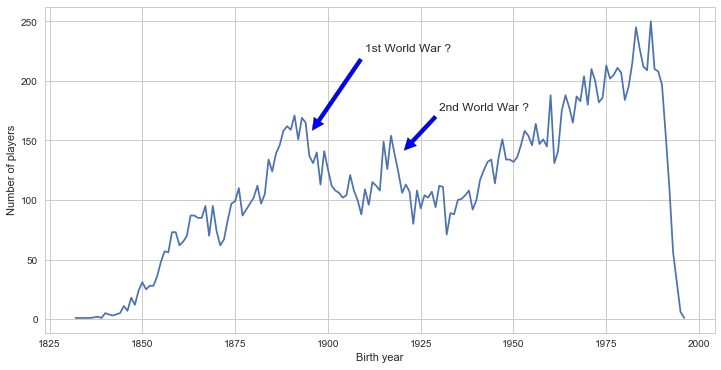

In [365]:
#We can use a point plot again:
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
ax.plot(birth_year_count["birthYear"]["mean"], birth_year_count["birthYear"]["count"])
ax.set(xlabel="Birth year", ylabel="Number of players")
ax.annotate("1st World War ?", xy=(1895., 155.), xytext=(1910., 225.), arrowprops=dict(facecolor='blue', shrink=0.05))
ax.annotate("2nd World War ?", xy=(1920., 140.), xytext=(1930., 175.), arrowprops=dict(facecolor='blue', shrink=0.05))

The higher error estimate is larger for players born after 1990 because we can see that the number of players decreases significantly. This causes a noisier signal.

In the period [1900, 1930), we also see two significant decreases of number of players. This might be explained by american young men involded in First and Second World War.

#### Carrier length

It is irrelevant to display carrier length of players born after 1980. As we have filtered out any player whom carrier is not over, we have introduced a bias towards recent players having a short carrier.

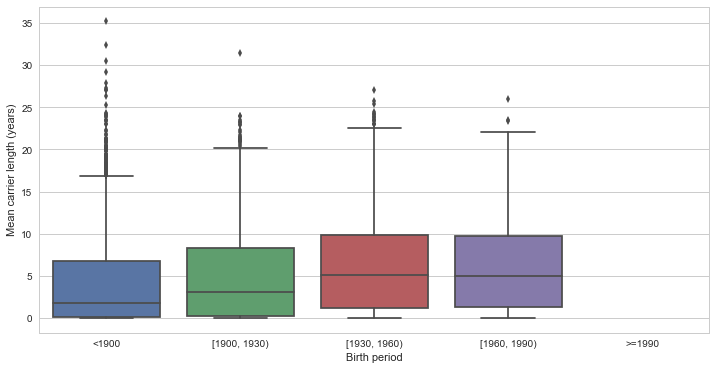

In [370]:
#It is irrelevant to display carrier length of players born after 1980.
carrier_length = carrier_df[carrier_df["birthYear"] <= 1980]

#We use a box plot this time
order = birth_periods_order(BIRTH_PERIODS)
figure = plt.figure(figsize=(12, 6))
ax = figure.add_subplot(111)
ax = sns.boxplot(x="birthPeriod", y="carrierLength", data=carrier_length, order=order, ax=ax)
ax.set(xlabel="Birth period", ylabel="Mean carrier length (years)")

The average carrier lenght of a player has slightly increased and is around 5 years. But we can see that the carrier length are really spread out with some players having a carrier longer than 25 years.

We can have a closer look to those players:

In [371]:
carrier_length_outliers = carrier_length[carrier_length["carrierLength"] > 30]
carrier_length_outliers.head(50)

,ageAtDebut,birthPeriod,birthYear,carrierLength,fullName
playerID,,,,,
altroni01,21.826146,<1900,1876.0,35.214237,Nick Altrock
minosmi01,23.386721,"[1900, 1930)",1925.0,31.463381,Minnie Minoso
olearch01,28.495551,<1900,1875.0,30.461328,Charley O'Leary
orourji01,21.650924,<1900,1850.0,32.405202,Jim O'Rourke


According to [Wikipedia](https://en.wikipedia.org/wiki/Nick_Altrock) Nick Altrock ends prematurely his carrier as a full-time player due to an injury but made appearances in the league until the age of 57.

<a id='Conclusions'/>

## Conclusions *[top](#Top)*

<a id='Appendix'>

## Appendix *[top](#Top)*

Checkout out Sebastian Rachka blog post related to table of contents in notebooks [here](http://sebastianraschka.com/Articles/2014_ipython_internal_links.html). His [GitHub](https://github.com/rasbt) page is also worth the detour for Python [tricks](https://github.com/rasbt/python_reference), data science stuff, machine learning...<hr>

Seaborn documentation comes with a [tutorial](https://seaborn.pydata.org/tutorial.html).<hr>